In [2]:
import numpy as np


class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None
        
        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        #np.mean：求平均值方法
        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        #self.m 点的数量
        #self.diff = y - y_hat
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [3]:
from sklearn.datasets import load_boston

In [4]:
data = load_boston()

In [5]:
losses = []

In [6]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
#randn函数返回一个或一组样本，具有标准正态分布。
W1_ = np.random.randn(n_features, n_hidden)

b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
#取整
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 200.267
Epoch: 101, Loss: 9.637
Epoch: 201, Loss: 5.707
Epoch: 301, Loss: 5.639
Epoch: 401, Loss: 7.195
Epoch: 501, Loss: 5.035
Epoch: 601, Loss: 6.260
Epoch: 701, Loss: 3.935
Epoch: 801, Loss: 5.222
Epoch: 901, Loss: 4.356
Epoch: 1001, Loss: 4.247
Epoch: 1101, Loss: 4.104
Epoch: 1201, Loss: 4.514
Epoch: 1301, Loss: 4.243
Epoch: 1401, Loss: 3.773
Epoch: 1501, Loss: 5.023
Epoch: 1601, Loss: 4.186
Epoch: 1701, Loss: 3.509
Epoch: 1801, Loss: 3.722
Epoch: 1901, Loss: 3.634
Epoch: 2001, Loss: 3.454
Epoch: 2101, Loss: 3.933
Epoch: 2201, Loss: 4.415
Epoch: 2301, Loss: 3.894
Epoch: 2401, Loss: 3.617
Epoch: 2501, Loss: 2.876
Epoch: 2601, Loss: 3.541
Epoch: 2701, Loss: 3.843
Epoch: 2801, Loss: 3.569
Epoch: 2901, Loss: 3.579
Epoch: 3001, Loss: 3.701
Epoch: 3101, Loss: 2.897
Epoch: 3201, Loss: 3.970
Epoch: 3301, Loss: 4.246
Epoch: 3401, Loss: 3.854
Epoch: 3501, Loss: 3.679
Epoch: 3601, Loss: 3.548
Epoch: 3701, Loss: 3.883
Epoch: 3801, Loss: 3.525
Epoc

In [10]:
graph

In [9]:
graph[0].

array([  1.10780291,  -0.85206157,  -1.78933037,  -1.71055732,
        -2.69257329,  -6.13174685,  -1.46995613,   6.71573535,
       -10.07011949,  -2.98023414])

In [6]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [7]:
forward(l2,graph)

array([[19.21767523],
       [15.64055008],
       [23.35986956],
       [22.40468702],
       [16.89463121],
       [12.13353818],
       [26.44694319],
       [32.96641724],
       [35.27919897],
       [24.25112302],
       [16.92448228],
       [14.05161832],
       [21.77211819],
       [23.27849903],
       [21.87075499],
       [ 9.37185018]])

In [8]:
import matplotlib.pyplot as plt

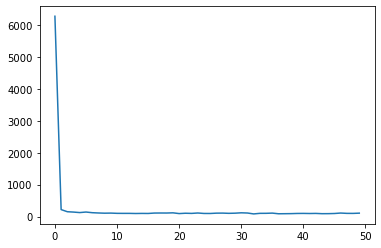

In [9]:
plt.plot(range(len(losses)), losses)

In [10]:
W2.value

array([[-7.09356653],
       [ 6.37112696],
       [ 4.85888709],
       [ 7.71812819],
       [ 4.69811938],
       [ 5.02622148],
       [ 9.1410029 ],
       [ 6.76214579],
       [ 6.58493952],
       [ 8.93537693]])

In [11]:
X_ = data['data']

In [12]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [13]:
import keras

Using TensorFlow backend.


In [14]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [15]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [16]:
model.fit(X_, y_, epochs=5000, batch_size=32)

============] - 0s 41us/step - loss: 84.4590 - mse: 84.4590
Epoch 4809/5000
506/506 [==============================] - 0s 36us/step - loss: 84.9473 - mse: 84.9473
Epoch 4810/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8097 - mse: 84.8097
Epoch 4811/5000
506/506 [==============================] - 0s 38us/step - loss: 85.0116 - mse: 85.0116
Epoch 4812/5000
506/506 [==============================] - 0s 47us/step - loss: 84.6326 - mse: 84.6326
Epoch 4813/5000
506/506 [==============================] - 0s 43us/step - loss: 84.6836 - mse: 84.6836
Epoch 4814/5000
506/506 [==============================] - 0s 38us/step - loss: 84.7850 - mse: 84.7850
Epoch 4815/5000
506/506 [==============================] - 0s 42us/step - loss: 85.1088 - mse: 85.1088
Epoch 4816/5000
506/506 [==============================] - 0s 38us/step - loss: 84.8670 - mse: 84.8670
Epoch 4817/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7060 - mse: 84.7060
Epoch 4818/50